In [204]:
import numpy as np
from qutip import tensor, Qobj


def kron(*args: Qobj) -> Qobj:
    '''Kronecker product of Qobj instances.

    Parameters
    ----------

    args : Qobj
        An ordered sequence of qutip.Qobj instances.
    '''
    if len(args) == 1:
        return args[0]
    return tensor(args[0], kron(*args[1:]))


def spectral_function(central_frequencies: float | list[float],
                      height: float | list[float],
                      width: float | list[float],
                      frequency_range: list[float] | np.ndarray | None = None,
                      negative_frequencies: bool = True):

    central_frequencies = np.atleast_1d(central_frequencies)
    height = np.atleast_1d(height)
    width = np.atleast_1d(width)
    if frequency_range is None:
        f_max = np.max(central_frequencies + 4 * width)
        df = np.min(width) / 100
        fr = np.arange(0, f_max + df, df, dtype=float)
    else:
        fr = np.array(frequency_range, dtype=float)
    sf = np.zeros_like(fr, dtype=float)
    for k, h in enumerate(height):
        w = width[k]
        cf = central_frequencies[k]
        sf += h * w**2 / ((fr - cf)**2 + w**2)
    if negative_frequencies:
        fr = np.concatenate((-np.flip(fr[1:]), fr))
        sf = np.concatenate((np.flip(sf[1:]), sf))
    return fr, sf


def gray_code_list(n: int) -> list[str]:
    return [f'{i ^ i >> 1:0{n}b}' for i in range(1 << n)]

**Excitonic System**

In [205]:
import warnings
from typing import Literal
import numpy as np
from scipy.linalg import ishermitian
from qutip import (Qobj, sigmaz, identity, destroy, basis, zero_ket, qzero)


class ExcitonicSystem:

    @property
    def e_el(self):
        return self._e_el

    @property
    def system_size(self):
        return self._system_size

    @property
    def dipole_moments(self):
        return self._dipole_moments

    @property
    def coupl_el(self):
        return self._coupl_el

    @property
    def state_type(self):
        return self._state_type

    @property
    def state(self):
        return self._state

    @staticmethod
    def check_state_type(func):
        def wrapper(self, *args, **kwargs):
            if self.state_type is None:
                return func(self, *args, **kwargs)
            else:
                raise ValueError(
                    "parameters cannot be changed after a state has been set.")
        return wrapper

    @staticmethod
    def check_validity(func):
        def wrapper(self, *args, **kwargs):
            result = func(self, *args, **kwargs)
            try:
                if (self.e_el.size == self.dipole_moments.size
                        == self.coupl_el.shape[0] == self.system_size):
                    self._validity = True
                else:
                    self._validity = False
            except AttributeError:
                self._validity = False
            return result
        return wrapper

    @e_el.setter
    @check_state_type
    @check_validity
    def e_el(self, energies: float | list[float] | np.ndarray):
        self._e_el = np.atleast_1d(energies)
        self.system_size = self.e_el.size

    @system_size.setter
    @check_state_type
    def system_size(self, size: int):
        self._system_size = size

    @dipole_moments.setter
    @check_state_type
    @check_validity
    def dipole_moments(self, dipoles: float | list[float] | np.ndarray | None):
        if dipoles is None:
            warnings.warn(
                'No dipole moments provided. Setting all to 1.')
            self._dipole_moments = np.ones(self.system_size)
        else:
            self._dipole_moments = np.atleast_1d(dipoles)

    @coupl_el.setter
    @check_state_type
    @check_validity
    def coupl_el(self, couplings: float | list[list[float]] | np.ndarray | None):
        if couplings is None:
            warnings.warn(
                'No couplings provided. Setting all to 0.')
            self._coupl_el = np.zeros((self.system_size, self.system_size))
        else:
            if np.isscalar(couplings) and self.system_size == 2:
                couplings = np.array([[0, couplings], [couplings, 0]])
            elif isinstance(couplings, list):
                couplings = np.atleast_2d(couplings)
            if not isinstance(couplings, np.ndarray):
                raise ValueError('Couplings in wrong format.')
            couplings -= np.diag(np.diag(couplings))
            if not ishermitian(couplings):
                raise ValueError('Coupling matrix is not Hermitian.')
            self._coupl_el = couplings

    def __init__(self,
                 energies: float | list[float] | np.ndarray,
                 couplings: float | list[float] | np.ndarray = None,
                 dipole_moments: float | list[float] | np.ndarray = None,
                 ):
        """ Create an `ExcitonicSystem` object.
        An `ExcitonicSystem` object contains the information about the excitonic part of a chromophore system intended as a collection of two-level electronic systems with a groung |0> and an excited |1> states.
        The exciton Hamiltonian is

        .. math:: H^{e} = - \sum_{i=1}^{N} \epsilon_{i}/2 \sigma^{z}_{i} + \sum_{i=1}^{N-1} \sum_{j>1}^{N} ( J_{ij} \sigma^{+}_{i} \sigma^{-}_{j} + h.c. )

        where :math:`\epsilon` are the energies and :math:`J` are the couplings.
        :math:`\sigma^{z}` is the Pauli-z operator (defined as |0><0| - |1><1|), while :math:`\sigma^{+}` (:math:`\sigma^{-}`) are the rising (lowering) ladder operators.

        Parameters
        ----------
        energies: list[float] | float | numpy.ndarray
            The electronic energy gaps of the chromphores of the network. It is a list, a number (for a single chromophore) or a monodimensional array.

        couplings: list[list[float]] | float | numpy.ndarray
            The electronic couplings between different chromophores of the network. It is in form of an Hermitian matrix with zeros in the diagonal. An off-diagonal element (i,j) represents the coupling that chromophore i experiences due to chromophore j. If the system is composed of only 2 chromophores, a float value is enough.

        dipole_moments: list[float] | float | numpy.ndarray
            The amplitude of the transition dipole moments of the chromophores. It is a list, a number (for a single chromophore) or a monodimensional array.
        """
        self._validity = False
        self._state_type = None
        self.e_el = energies
        self.dipole_moments = dipole_moments
        self.coupl_el = couplings

    def set_state(self,
                  state_type: Literal['state', 'delocalized excitation',
                                      'localized excitation', 'ground'] = 'ground',
                  state: list | np.ndarray | int = 0,
                  ):
        """Set the `ExcitonicSystem` electronic ket state.
        Note that in this version of the code only pure states are accepted.

        Parameters
        ----------
        state_type : str
            Type of the input state. It must be one of the following: 'state', 'delocalized excitation', 'localized excitation', 'ground'.

        state: list | np.ndarray | int
            The state of the system. The input is given by the selected state_type:
            - `'state'`: It requires a list of coefficients for the :math:`2^{N}` states that compose the electronic Hilbert space. A standard binary ordering and local basis set are intended, that is to say, for N=3 state `[0., 0., 0., 1.+0.j, 0., 0., 0., 0.] = |011>` denotes a double excitation state with both chromophore 0 and 1 excited. 
            - `'delocalized excitation'`: It takes a list of N (complex) coefficients that describe the superposition of single excitation states. For example, for N=3, `[c_001, c_010, c_100] = [0., 1./sqrt(2), 1./sqrt(2)] = 1/sqrt(2) |010> + 1/sqrt(2) |100>`.
            - `'localized excitation'`: It takes an integer that denotes the excited chromophore. Chromophores are numbered from 0 to N-1.
            - `'ground'`: It does not require any input. The system is in the global ground state.
        """
        valid_state_types = ('state', 'delocalized excitation',
                             'localized excitation', 'ground')
        if not self._validity:
            raise ValueError('System is not valid.')
        if state_type not in valid_state_types:
            raise ValueError('Invalid state type.')
        if state_type in ('state', 'delocalized excitation'):
            if not isinstance(state, (list, np.ndarray)):
                raise ValueError('State must be a list or numpy array.')
            state = np.array(state, dtype=complex)
            expected_size = 2**self.system_size if state_type == 'state' else self.system_size
            if state.size != expected_size:
                raise ValueError('State must match the system size.')
            norm = np.sum(np.abs(state)**2)
            if not np.isclose(norm, 1):
                state /= np.sqrt(norm)
                warnings.warn('State was not normalized. Normalizing.')
            state = state.tolist()
        elif state_type == 'localized excitation':
            if not isinstance(state, int):
                raise ValueError('State must be an integer.')
            if state < 0 or state >= self.system_size:
                raise ValueError('State must be within the system size.')
        elif state_type == 'ground':
            state = 0
        self._state_type = state_type
        self._state = state

    def todict(self) -> dict:
        init_dict = self.__dict__
        sys_dict = {'class': type(self)}
        for key, value in init_dict.items():
            new_key = key[1:] if key.startswith('_') else key
            sys_dict[new_key] = value.tolist() if isinstance(
                value, np.ndarray) else value
        return sys_dict

    def get_e_Hamiltonian(self):
        '''Returns the Frenkel-exciton Hamiltonian.
        '''
        if not self._validity:
            raise ValueError(
                'The system is not valid.')
        sz = sigmaz()
        sm = destroy(2)
        sp = sm.dag()
        I = identity(2)
        H = qzero(dimensions=[2]*self.system_size)
        for i in range(self.system_size):
            H += -0.5 * self.e_el[i] * \
                kron(*[I]*(self.system_size-i-1), sz, *[I]*i)
            for j in range(i+1, self.system_size):
                H += self.coupl_el[i, j] * \
                    (kron(*[I]*(self.system_size-j-1), sm, *[I]*(j-i-1), sp, *[I]*i)
                     + kron(*[I]*(self.system_size-j-1), sp, *[I]*(j-i-1), sm, *[I]*i))
        return H

    def get_e_state(self):
        '''Returns the ket state of the system.
        '''
        if not self._validity:
            raise ValueError(
                'The system is not valid.')
        if self._state_type == 'ground':
            state = basis([2] * self.system_size, [0] * self.system_size)
        elif self._state_type == 'state':
            state = Qobj(np.array(self.state), dims=[
                         [2] * self.system_size, [1] * self.system_size], type='ket')
        elif self._state_type == 'delocalized excitation':
            state = zero_ket(dimensions=[2] * self.system_size)
            for nc, c in enumerate(self.state):
                position = list(
                    map(int, bin(1 << nc)[2:].zfill(self.system_size)))
                state += c * basis([2] * self.system_size, position)
        elif self._state_type == 'localized excitation':
            position = list(
                map(int, bin(1 << self.state)[2:].zfill(self.system_size)))
            state = basis([2] * self.system_size, position)
        return state

**ChromophoreSystem**

In [206]:
class ChromophoreSystem(ExcitonicSystem):

    @property
    def mode_dict(self):
        return self._mode_dict

    @mode_dict.setter
    def mode_dict(self, md):
        self._mode_dict = md

    def __init__(self,
                 energies: list[float] | float | np.ndarray = None,
                 couplings: list[list[float]] | float | np.ndarray = None,
                 dipole_moments: list[float] | float | np.ndarray = None,
                 excitonic_system: ExcitonicSystem = None,
                 frequencies_pseudomode: list[float] | float | np.ndarray = None,
                 levels_pseudomode: int = None,
                 couplings_ep: list[float] | float | np.ndarray = None,
                 ):
        if excitonic_system:
            super().__init__(energies=excitonic_system.e_el,
                             couplings=excitonic_system.coupl_el,
                             dipole_moments=excitonic_system.dipole_moments,
                             )
            try:
                self.set_state(excitonic_system.state_type,
                               excitonic_system.state)
            except:
                pass
        else:
            super().__init(energies=energies,
                           couplings=couplings,
                           dipole_moments=dipole_moments,
                           )
        self._mode_dict = None
        if frequencies_pseudomode is not None:
            self.pseudomode(frequencies_pseudomode=frequencies_pseudomode,
                            levels_pseudomode=levels_pseudomode,
                            couplings_ep=couplings_ep,
                            )

    def pseudomodes(self,
                    frequencies_pseudomode: list[float] | float = None,
                    levels_pseudomode: list[int] | int = None,
                    couplings_ep: list[float] | float = None,
                    ):
        if frequencies_pseudomode is None:
            raise ValueError(
                'The pseudomode frequencies must be specified.')
        frequencies_pseudomode = np.atleast_1d(frequencies_pseudomode)

        if levels_pseudomode is None:
            raise ValueError(
                'The pseudomode levels must be specified.')
        levels_pseudomode = np.atleast_1d(levels_pseudomode)
        if levels_pseudomode.size != frequencies_pseudomode.size:
            raise ValueError(
                'The number of pseudomode levels must match the number of pseudomode frequencies.')
        if min(levels_pseudomode) < 2:
            raise ValueError(
                'The pseudomode levels must be greater than 1.')

        if couplings_ep is None:
            raise ValueError(
                'The electronic-pseudomode couplings must be specified.')
        couplings_ep = np.atleast_1d(couplings_ep)
        if couplings_ep.size != frequencies_pseudomode.size:
            raise ValueError(
                'The number of electronic-pseudomode couplings must match the number of pseudomode frequencies.')

        state_mode = self.__set_mode_state(levels_pseudomode)

        pseudomode_dict = {'omega_mode': frequencies_pseudomode,
                           'lvl_mode': levels_pseudomode,
                           'coupl_ep': couplings_ep,
                           'state_mode': state_mode
                           }
        self.mode_dict = pseudomode_dict

    def __set_mode_state(self,
                         levels_pseudomode: np.ndarray,
                         ):
        state_mode = [[] for _ in levels_pseudomode]
        for i, levels in enumerate(levels_pseudomode):
            state_mode[i] = [1.+0.j] + [0.+0.j]*(levels-1)
        return state_mode

    def get_state_mode(self,
                       mode_number: int | None = None,
                       ):
        if mode_number is None:
            states = []
            for i, mode in enumerate(self.mode_dict['state_mode']):
                state = zero_ket(dimensions=[self.mode_dict['lvl_mode'][i]])
                for j, mode_lvl in enumerate(mode):
                    state += mode_lvl * \
                        basis(self.mode_dict['lvl_mode'][i], j)
                states.append(state)
            return states
        if not isinstance(mode_number, int):
            raise ValueError('The mode_number must be an integer.')
        if mode_number >= len(self.mode_dict['lvl_mode']):
            raise ValueError(
                'The mode_number must be a valid pseudomode index.')
        state = zero_ket(
            dimensions=self.mode_dict['lvl_mode'][mode_number])
        for i, mode_lvl in enumerate(self.mode_dict['state_mode'][mode_number]):
            state += mode_lvl * \
                basis(self.mode_dict['lvl_mode'][mode_number], i)
        return state

    def get_p_Hamiltonian(self):
        W = len(self.mode_dict['omega_mode'])
        d = list(self.mode_dict['lvl_mode'])
        Id = [identity(d[k]) for k in range(W)]
        H = qzero(dimensions=d)
        for k in range(W):
            a = destroy(d[k])
            H += self.mode_dict['omega_mode'][k] * \
                tensor(*[Id[i] if i != k else a.dag() * a for i in range(W)])
        return H

    def get_ep_Hamiltonian(self):
        N = self.system_size
        W = len(self.mode_dict['omega_mode'])
        d = list(self.mode_dict['lvl_mode'])
        Id = [identity(d[k]) for k in range(W)]
        I = identity(2)
        sz = sigmaz()
        H = qzero(dimensions=[2]*N + d*N)
        for i in range(N):
            for k in range(W):
                a = destroy(d[k])
                H += self.mode_dict['coupl_ep'][k]/2 * \
                    tensor(*[I]*(N-i-1), I-sz, *[I]*i, *Id*(N-i-1),
                           *[Id[j] if j != k else a.dag() + a for j in range(W)], *Id*i)
        return H

    def get_global_Hamiltonian(self):
        N = self.system_size
        W = len(self.mode_dict['omega_mode'])
        I = identity(2)
        d = list(self.mode_dict['lvl_mode'])
        Id = [identity(d[k]) for k in range(W)]
        H_e = self.get_e_Hamiltonian()
        H_p = self.get_p_Hamiltonian()
        H_ep = self.get_ep_Hamiltonian()
        H = tensor(H_e, *Id*N) + H_ep
        for i in range(N):
            H += tensor(*[I]*N, *Id*(N-i-1), H_p, *Id*i)
        return H

    def extract_ExcitonicSystem(self):
        e_sys = ExcitonicSystem(energies=self.e_el,
                                couplings=self.coupl_el,
                                dipole_moments=self.dipole_moments,
                                )
        try:
            e_sys.set_state(self.state_type, self.state)
        except ValueError:
            warnings.warn(
                'The state has not been set.')
        return e_sys

In [207]:
def set_mode_state(levels_pseudomode: np.ndarray,
                   ):
    state_mode = [[] for _ in levels_pseudomode]
    for i, levels in enumerate(levels_pseudomode):
        state_mode[i] = [1.+0.j] + [0.+0.j]*(levels-1)
    return state_mode


levels = np.array([3, 2, 2])
state_mode = set_mode_state(levels)

print(state_mode)

[[(1+0j), 0j, 0j], [(1+0j), 0j], [(1+0j), 0j]]


**clevolve**

In [208]:
from qutip import mesolve, sesolve
from qutip.solver import Result


def clevolve(system: ChromophoreSystem | ExcitonicSystem,
             time: float | list[float] | np.ndarray,
             rates: float | list[float] | None = None,
             measure_populations: bool = True,
             state_overwrite: Qobj = None,
             verbose: bool = True,
             ) -> Result:
    if type(system) not in (ChromophoreSystem, ExcitonicSystem):
        raise ValueError(
            'The system must be an instance of ChromophoreSystem or ExcitonicSystem.')
    if not system._validity:
        raise ValueError(
            'The system is not valid.')
    if type(system) is ChromophoreSystem and system.mode_dict is None:
        warnings.warn(
            'The Pseudomodes are not specified. Executing the dynamics as an ExcitonicSystem.')
        return clevolve(system.extract_ExcitionicSystem(),
                        time,
                        rates,
                        measure_populations,
                        )

    time = [time] if np.isscalar(time) else time

    if type(system) is ExcitonicSystem and \
            not np.isscalar(rates) and rates is not None:
        raise ValueError(
            'The rates must be a scalar for ExcitonicSystem.')
    elif type(system) is ChromophoreSystem and \
            rates is not None:
        rates = [rates] if np.isscalar(rates) else rates
        if len(rates) != len(system.mode_dict['omega_mode']):
            raise ValueError(
                'The number of dephasing rates is different from the number of pseudomodes per chromophore.')

    if state_overwrite is None:
        state = system.get_e_state()
    else:
        state = state_overwrite

    if type(system) is ExcitonicSystem:
        results = __evolve_exsys(system,
                                 state,
                                 time,
                                 rates,
                                 measure_populations,
                                 )
    elif type(system) is ChromophoreSystem:
        results = __evolve_cpsys(system,
                                 state,
                                 time,
                                 rates,
                                 measure_populations,
                                 )
    ending_sentense(verbose)
    return results


def __evolve_exsys(system: ExcitonicSystem,
                   state: Qobj,
                   time: float | list[float] | np.ndarray,
                   rates: float | None,
                   measure_populations: bool,
                   ):
    def e_ops(N, op):
        nonlocal measure_populations
        if not measure_populations:
            return None
        I = identity(2)
        return [kron(*[I]*(N-i-1), op, *[I]*i) for i in range(N)]
    e_ops_ = e_ops(system.system_size, basis(2, 1).proj())
    if rates is None:
        if state.type == 'ket':
            results = sesolve(system.get_e_Hamiltonian(),
                              state,
                              time,
                              e_ops=e_ops_,
                              )
        else:
            results = mesolve(system.get_e_Hamiltonian(),
                              state,
                              time,
                              e_ops=e_ops_,
                              )
    else:
        c_ops_ = e_ops(system.system_size, np.sqrt(rates) * sigmaz())
        results = mesolve(system.get_e_Hamiltonian(),
                          state,
                          time,
                          c_ops=c_ops_,
                          e_ops=e_ops_,
                          )
    return results


def __evolve_cpsys(system: ChromophoreSystem,
                   state: Qobj,
                   time: float | list[float] | np.ndarray,
                   rates: float | list[float] | None,
                   measure_populations: bool,
                   ):
    def e_ops(N, op, Id_pseudomodes):
        nonlocal measure_populations
        if not measure_populations:
            return None
        I = identity(2)
        return [kron(*[I]*(N-i-1), op, *[I]*i, *Id_pseudomodes*N) for i in range(N)]

    def c_ops(N, rates, d, Id_pseudomodes):
        I = identity(2)
        for i in range(N):
            for k, rate in enumerate(rates):
                a = destroy(d[k])
                yield np.sqrt(rate) * \
                    tensor(*[I]*N, *Id_pseudomodes*(N-i-1),
                           *[Id_pseudomodes[j] if j != k else a
                             for j in range(len(rates))], *Id_pseudomodes*i)
    W = len(system.mode_dict['omega_mode'])
    d = list(system.mode_dict['lvl_mode'])
    Id = [identity(d[k]) for k in range(W)]

    if state.shape[0] == 2**system.system_size:
        state_modes = system.get_state_mode()
        state0 = tensor(state, *[state_modes[k]
                        for k in range(W)] * system.system_size)
    else:
        state0 = state

    e_ops_ = e_ops(system.system_size, basis(2, 1).proj(), Id)
    if rates is None:
        if state0.type == 'ket':
            results = sesolve(system.get_global_Hamiltonian(),
                              state0,
                              time,
                              e_ops=e_ops_,
                              )
        else:
            results = mesolve(system.get_global_Hamiltonian(),
                              state0,
                              time,
                              e_ops=e_ops_,
                              )
    else:
        c_ops_ = list(c_ops(system.system_size, rates, d, Id))
        results = mesolve(system.get_global_Hamiltonian(),
                          state0,
                          time,
                          c_ops=c_ops_,
                          e_ops=e_ops_,
                          )
    return results


def ending_sentense(verbose: bool):
    if verbose:
        print('The evolution has been completed.')

**qevolve**

In [175]:
import itertools
from math import prod
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit.quantum_info import SparsePauliOp, DensityMatrix
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter, SuzukiTrotter
from qiskit_aer import AerSimulator, AerError


def qevolve(system: ChromophoreSystem | ExcitonicSystem,
            time: float | list[float] | np.ndarray,
            shots: int | None = None,
            initialize_circuit: bool = True,
            Trotter_number: int = 1,
            Trotter_order: int = 1,
            dt: float = None,
            coll_rates: float | list[float] | None = None,
            GPU: bool = False,
            verbose: bool = True,
            ) -> QuantumCircuit | list[QuantumCircuit] | Result:
    verboseprint = print if verbose else lambda *a, **k: None

    if type(system) not in (ChromophoreSystem, ExcitonicSystem):
        raise ValueError(
            'The system must be an instance of ChromophoreSystem or ExcitonicSystem.')
    if not system._validity:
        raise ValueError(
            'The system is not valid.')
    if type(system) is ChromophoreSystem and system.mode_dict is None:
        warnings.warn(
            'The Pseudomodes are not specified. Executing the dynamics as an ExcitonicSystem.')
        return qevolve(system.extract_ExcitonicSystem(),
                       time,
                       shots,
                       initialize_circuit,
                       Trotter_number,
                       Trotter_order,
                       dt,
                       coll_rates,
                       GPU,
                       verbose,
                       )

    if type(system) is ExcitonicSystem:
        if not np.isscalar(coll_rates) and coll_rates is not None:
            raise ValueError(
                'coll_rates must be a scalar for ExcitonicSystem.')
    elif type(system) is ChromophoreSystem:
        if coll_rates is not None:
            coll_rates = np.atleast_1d(coll_rates)
            if len(coll_rates) != len(system.mode_dict['omega_mode']):
                raise ValueError(
                    'The number of collision rates is different from the number of pseudomodes per chromophore.')

    # Constructing the circuit
    qc, register_list = __create_circuit(system, coll_rates is not None)

    # Circuit initialization
    if initialize_circuit:
        qc = __circuit_init(qc, register_list, system)
        qc.barrier(label='Initialization')

    verboseprint('Start creating the circuits...')

    # Propagation
    qc_list = __propagation(qc,
                            register_list,
                            system,
                            time,
                            Trotter_number,
                            Trotter_order,
                            dt,
                            coll_rates,
                            shots,
                            )

    verboseprint('Circuits created...')

    # Return the circuit
    if shots is None:
        return qc_list
    # Execute the circuit
    elif shots == 0:
        verboseprint('Extracting Density Matrix...')
        size = range(system.system_size)
        results = []
        for qc in qc_list:
            dm = DensityMatrix(qc)
            probability = dm.probabilities_dict(qargs=size)
            results.append(probability)
    else:
        verboseprint('Start measuring the circuits...')
        simulator = AerSimulator()
        if GPU:
            try:
                simulator.set_options(device='GPU')
            except AerError as e:
                print(e)
        results = simulator.run(qc_list, shots=shots).result()
    return results


def __create_circuit(system: ChromophoreSystem | ExcitonicSystem,
                     bool_ancillae: bool,
                     ):
    register_list = []
    # Exciton system qubits
    qr_e = QuantumRegister(system.system_size, name='sys_e')
    register_list.append(qr_e)
    # Pseudomode qubits
    if type(system) is ChromophoreSystem:
        qr_p_list = []
        for i in range(system.system_size):
            for k, d_k in enumerate(system.mode_dict['lvl_mode']):
                n_qubits = np.log2(d_k).astype(int)
                qr_p_list.append(
                    QuantumRegister(n_qubits, name=f'mode({i},{k})'))
        register_list += qr_p_list
    # Ancillae qubits for collision model
    if bool_ancillae:
        qr_a = AncillaRegister(1, name='ancillae')
        register_list.append(qr_a)
    qc = QuantumCircuit(*register_list)
    return qc, register_list


def __circuit_init(qc: QuantumCircuit,
                   register_list: list[QuantumRegister],
                   system: ChromophoreSystem | ExcitonicSystem,
                   ) -> QuantumCircuit:
    qr_e = register_list[0]
    if system.state_type == 'state':
        qc.initialize(system.state, qr_e)
    elif system.state_type == 'delocalized excitation':
        relevant_qubits = np.where(np.array(system.state) != 0)[0].tolist()
        relevant_state = np.zeros(2**len(relevant_qubits), dtype=complex)
        for ni, i in enumerate(relevant_qubits):
            relevant_state[2**ni] = system.state[i]
        qc_relevant = QuantumCircuit(len(relevant_qubits))
        qc_relevant.initialize(relevant_state)
        qc.compose(qc_relevant,
                   qubits=[qr_e[i] for i in relevant_qubits],
                   inplace=True,
                   )
    elif system.state_type == 'localized excitation':
        qc.x(qr_e[system.state])
    return qc


def __propagation(qc: QuantumCircuit,
                  register_list: list[QuantumRegister],
                  system: ChromophoreSystem | ExcitonicSystem,
                  time: float | list[float] | np.ndarray,
                  Trotter_number: int,
                  Trotter_order: int,
                  dt: float,
                  coll_rates: float | list[float] | None,
                  shots: int | None,
                  ):
    if dt is None:
        if np.isscaler(time):
            dt_Trotter = time / Trotter_number
        else:
            dt_Trotter = (time[1] - time[0]) / Trotter_number
        dt = dt_Trotter
        Trotter_number = 1
    else:
        dt_Trotter = dt / Trotter_number

    time = np.atleast_1d(time)
    tolerance = 1e-10
    if all(abs(t - np.round(t / dt) * dt) < tolerance for t in time):
        number_of_dts = np.round(time / dt).astype(int)
    else:
        raise ValueError(
            'The time steps must be multiples of the time step dt.')

    # Composing the circuit for a Trotter step
    qc_ts = __Trotter_step(system,
                           dt_Trotter,
                           Trotter_order,
                           coll_rates is not None,
                           )

    # Composing the circuit for the collisions
    if coll_rates is not None:
        qc_collision = __collision_circuit(system,
                                           dt,
                                           Trotter_order,
                                           coll_rates,
                                           )

    # Adding a classical register when needed
    if shots != 0 and shots is not None:
        creg = ClassicalRegister(system.system_size)
        qc.add_register(creg)

    # Propagation
    qc_list = []
    for ndt in range(np.max(number_of_dts) + 1):
        if ndt != 0:
            for _ in range(Trotter_number):
                qc.compose(qc_ts, inplace=True)
            qc.barrier(label=f'Trot step {ndt}')
            if coll_rates is not None:
                qc.compose(qc_collision, inplace=True)
                qc.barrier(label=f'Coll step {ndt}')
        if ndt in number_of_dts:
            qc_copy = qc.copy()
            if shots != 0 and shots is not None:
                qc_copy.measure(register_list[0], creg)
            qc_list.append(qc_copy)
    return qc_list


def __Trotter_step(system: ChromophoreSystem | ExcitonicSystem,
                   dt: float,
                   Trotter_order: int,
                   bool_ancillae: bool,
                   ) -> QuantumCircuit:
    qc, register_list = __create_circuit(system, bool_ancillae)
    qr_e = register_list[0]
    qc.compose(__sys_evolution(system, dt, Trotter_order),
               qubits=qr_e,
               inplace=True,
               )
    qc.barrier(label='sys evol')
    if type(system) is ChromophoreSystem:
        N = system.system_size
        W = len(system.mode_dict['omega_mode'])
        qr_p_list = register_list[1:-1] if bool_ancillae else register_list[1:]
        for k in range(W):
            _, _, a_p_a_dag_dict, a_dag_a_dict = __mode_operators(system, k)
            n_qubits_mode_k = len(list(a_dag_a_dict.keys())[0])

            qc_mode_evo_k = __mode_evolution(system.mode_dict['omega_mode'][k],
                                             a_dag_a_dict,
                                             dt,
                                             Trotter_order,
                                             )

            qc_system_int_k = __sys_mode_interaction(system.mode_dict['coupl_ep'][k],
                                                     a_p_a_dag_dict,
                                                     dt,
                                                     Trotter_order,
                                                     )
            for i in range(N):
                qr_p_ik = qr_p_list[i*W + k]
                qc.compose(qc_mode_evo_k, qubits=qr_p_ik, inplace=True)
                qubit_list = [qr_e[i]] + qr_p_ik[:]
                qc.compose(qc_system_int_k, qubits=qubit_list, inplace=True)
                qc.barrier(label=f'sys_{i}-mode_{k} int')
    return qc


def __sys_evolution(system: ChromophoreSystem | ExcitonicSystem,
                    dt: float,
                    Trotter_order: int,
                    ) -> QuantumCircuit:
    energies = system.e_el
    couplings = system.coupl_el
    N = system.system_size
    qc = QuantumCircuit(N)

    # Create the dictionary of Pauli operations
    op_dict = {}
    for i in range(N):
        if energies[i] != 0.:
            op_str = ''.join([*['I']*(N-i-1), 'Z', *['I']*i])
            op_dict[op_str] = - energies[i] / 2
    for i in range(N):
        for j in range(i+1, N):
            if couplings[i, j] != 0.:
                for pauli in ['X', 'Y']:
                    op_str = ''.join(
                        [*['I']*(N-j-1), pauli, *['I']*(j-i-1), pauli, *['I']*i])
                    op_dict[op_str] = couplings[i, j] / 2

    # Selecting the Trotter class
    Trotter = __Trotter_class(Trotter_order)

    # Creating the gates
    pauli_gates = SparsePauliOp(list(op_dict.keys()),
                                coeffs=list(op_dict.values()),
                                )
    evolution_gate = PauliEvolutionGate(pauli_gates,
                                        time=dt,
                                        synthesis=Trotter,
                                        )

    # Appending to qc
    qc.append(evolution_gate, range(N))
    return qc.decompose(reps=2)


def __Trotter_class(Trotter_order: int):
    if Trotter_order == 1:
        return LieTrotter()
    else:
        return SuzukiTrotter(order=Trotter_order)


def __mode_operators(system: ChromophoreSystem,
                     k: int,
                     ):
    def add_to_dict(target_dict: dict,
                    Pauli_ops: list[list[str]],
                    Pauli_coeffs: list[list[complex]],
                    mul: float,
                    ):
        Pauli_strings = [''.join(p) for p in itertools.product(*Pauli_ops)]
        Pauli_coeffs_comb = [mul * prod(c)
                             for c in itertools.product(*Pauli_coeffs)]
        for i, p in enumerate(Pauli_strings):
            target_dict[p] = target_dict.get(p, 0) + Pauli_coeffs_comb[i]
        return target_dict

    d_k = system.mode_dict['lvl_mode'][k]
    n_qubits = np.log2(d_k).astype(int)

    # Constructing a list of Gray codes for the pseudomode
    pseudo_encoded = gray_code_list(n_qubits)

    # a
    a_dict = {}
    for index in range(1, d_k):
        Pauli_ops = []
        Pauli_coeffs = []
        for i in range(n_qubits):
            if pseudo_encoded[index - 1][i] == pseudo_encoded[index][i]:
                Pauli_ops.append(['I', 'Z'])
                Pauli_coeffs.append(
                    [1/2, 1/2] if pseudo_encoded[index-1][i] == '0' else [1/2, -1/2])
            else:
                Pauli_ops.append(['X', 'Y'])
                Pauli_coeffs.append(
                    [1/2, 1.j/2] if pseudo_encoded[index-1][i] == '0' else [1/2, -1.j/2])
        a_dict = add_to_dict(
            a_dict, Pauli_ops, Pauli_coeffs, np.sqrt(index))

    # a^dagger
    a_dag_dict = {}
    for index in range(d_k - 1):
        Pauli_ops = []
        Pauli_coeffs = []
        for i in range(n_qubits):
            if pseudo_encoded[index + 1][i] == pseudo_encoded[index][i]:
                Pauli_ops.append(['I', 'Z'])
                Pauli_coeffs.append(
                    [1/2, 1/2] if pseudo_encoded[index+1][i] == '0' else [1/2, -1/2])
            else:
                Pauli_ops.append(['X', 'Y'])
                Pauli_coeffs.append(
                    [1/2, 1.j/2] if pseudo_encoded[index+1][i] == '0' else [1/2, -1.j/2])
        a_dag_dict = add_to_dict(
            a_dag_dict, Pauli_ops, Pauli_coeffs, np.sqrt(index+1))

    # a + a^dagger
    a_p_a_dag_dict = {}
    for key in a_dict:
        if a_dict[key] != -a_dag_dict[key]:
            a_p_a_dag_dict[key] = a_dict[key] + a_dag_dict[key]

    # a^dagger * a
    a_dag_a_dict = {}
    for index in range(d_k):
        Pauli_ops = []
        Pauli_coeffs = []
        for i in range(n_qubits):
            Pauli_ops.append(['I', 'Z'])
            Pauli_coeffs.append(
                [1/2, 1/2] if pseudo_encoded[index][i] == '0' else [1/2, -1/2])
        a_dag_a_dict = add_to_dict(
            a_dag_a_dict, Pauli_ops, Pauli_coeffs, index)

    return a_dict, a_dag_dict, a_p_a_dag_dict, a_dag_a_dict


def __mode_evolution(frequency_mode: float,
                     a_dag_a_dict: dict,
                     dt: float,
                     Trotter_order: int,
                     ) -> QuantumCircuit:
    n_qubits = len(list(a_dag_a_dict.keys())[0])

    qr_p_k = QuantumRegister(n_qubits)
    qc = QuantumCircuit(qr_p_k)

    if frequency_mode != 0:
        Trotter = __Trotter_class(Trotter_order)

        coeffs = frequency_mode * np.array(list(a_dag_a_dict.values()))
        pauli_gates = SparsePauliOp(list(a_dag_a_dict.keys()),
                                    coeffs=coeffs,
                                    )
        evolution_gate = PauliEvolutionGate(pauli_gates,
                                            time=dt,
                                            synthesis=Trotter,
                                            )
        qc.append(evolution_gate, qr_p_k)
    return qc.decompose(reps=2)


def __sys_mode_interaction(interaction_strength: ChromophoreSystem,
                           a_p_a_dag_dict: dict,
                           dt: float,
                           Trotter_order: int,
                           ) -> QuantumCircuit:
    qr_e = QuantumRegister(1)
    n_qubits = len(list(a_p_a_dag_dict.keys())[0])

    qr_p_k = QuantumRegister(n_qubits)
    qc = QuantumCircuit(qr_e, qr_p_k)

    I = SparsePauliOp('I')
    Z = SparsePauliOp('Z')

    if interaction_strength != 0:
        Trotter = __Trotter_class(Trotter_order)

        coeffs = np.array(list(a_p_a_dag_dict.values()))
        a_p_a_dag_gates = SparsePauliOp(list(a_p_a_dag_dict.keys()),
                                        coeffs=coeffs,
                                        )

        H_coll_gate = a_p_a_dag_gates ^ ((0.5 * I) - (0.5 * Z))
        H_coll_gate = interaction_strength * H_coll_gate.simplify()
        evolution_gate = PauliEvolutionGate(H_coll_gate,
                                            time=dt,
                                            synthesis=Trotter,
                                            )
        qubit_list = [qr_e[0]] + qr_p_k[:]
        qc.append(evolution_gate, qubit_list)
    return qc.decompose(reps=2)


def __collision_circuit(system: ChromophoreSystem | ExcitonicSystem,
                        dt: float,
                        Trotter_order: int,
                        coll_rates: float | list[float],
                        ) -> QuantumCircuit:
    if type(system) is ExcitonicSystem:
        return __collisions_exsys(system, dt, coll_rates)
    elif type(system) is ChromophoreSystem:
        return __collisions_cpsys(system, dt, Trotter_order, coll_rates)


def __collisions_exsys(system: ExcitonicSystem,
                       dt: float,
                       coll_rates: float,
                       ) -> QuantumCircuit:
    qc, register_list = __create_circuit(system, coll_rates is not None)
    qr_e = register_list[0]
    qr_a = register_list[-1]
    for i in range(system.system_size):
        qc.rzx(2 * np.sqrt(coll_rates) * np.sqrt(dt), qr_e[i], qr_a[0])
        qc.reset(qr_a[0])
        qc.barrier(label=f'Collision {i}')
    return qc


def __collisions_cpsys(system: ChromophoreSystem,
                       dt: float,
                       Trotter_order: int,
                       coll_rates: list[float],
                       ) -> QuantumCircuit:
    N = system.system_size
    W = len(system.mode_dict['omega_mode'])
    qc, register_list = __create_circuit(system, coll_rates is not None)
    qr_p_list = register_list[1:-1]
    qr_a = register_list[-1]

    Trotter = __Trotter_class(Trotter_order)

    X = SparsePauliOp('X')
    Y = SparsePauliOp('Y')

    for k in range(W):
        if coll_rates[k] != 0:
            a_dict, a_dag_dict, _, _ = __mode_operators(system, k)

            # Creating the gates
            a_pauli_gates = SparsePauliOp(
                list(a_dict.keys()), coeffs=np.array(list(a_dict.values())))
            a_dag_pauli_gates = SparsePauliOp(
                list(a_dag_dict.keys()), coeffs=np.array(list(a_dag_dict.values())))
            H_coll_gate = ((a_pauli_gates ^ ((0.5 * X) - (0.5j * Y))) +
                           (a_dag_pauli_gates ^ ((0.5 * X) + (0.5j * Y))))
            # Sum repeated Pauli strings and remove zeros
            H_coll_gate = np.sqrt(coll_rates[k] / dt) * H_coll_gate.simplify()
            evolution_gate = PauliEvolutionGate(H_coll_gate,
                                                time=dt,
                                                synthesis=Trotter)

            for i in range(N):
                qr_p_ik = qr_p_list[i*W + k]
                qubit_list = [qr_a[0]] + qr_p_ik[:]
                qc.append(evolution_gate, qubit_list)
                qc.reset(qr_a[0])
                qc.barrier(label=f'Collision {i}')
    return qc.decompose(reps=2)

**Excitonic system test**

In [176]:
from scipy.linalg import toeplitz

epsilon = [1, 2]
J = toeplitz([0., 1.])
print(J)

esys = ExcitonicSystem(energies=epsilon, couplings=J)

[[0. 1.]
 [1. 0.]]


/tmp/ipykernel_25951/960698599.py:72: UserWarning: Equal dipole moments are assumed for all chromophores
  warnings.warn(


In [177]:
print(esys.e_el)
print(esys.coupl_el)
print(esys.dipole_moments)
print(esys.system_size)

[1 2]
[[0. 1.]
 [1. 0.]]
[1. 1.]
2


In [178]:
esys.get_e_Hamiltonian()

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[-1.5  0.   0.   0. ]
 [ 0.  -0.5  1.   0. ]
 [ 0.   1.   0.5  0. ]
 [ 0.   0.   0.   1.5]]

In [179]:
# esys.set_state(state_type='delocalized excitation',
#                state=[1/np.sqrt(2), 1/np.sqrt(2)])

esys.set_state(state_type='localized excitation', state=0)

In [180]:
esys.get_e_state()

Quantum object: dims=[[2, 2], [1, 1]], shape=(4, 1), type='ket', dtype=Dense
Qobj data =
[[0.]
 [1.]
 [0.]
 [0.]]

In [181]:
esys.todict()

{'class': __main__.ExcitonicSystem,
 'system_size': 2,
 'e_el': [1, 2],
 'dipole_moments': [1.0, 1.0],
 'coupl_el': [[0.0, 1.0], [1.0, 0.0]],
 'validity': True,
 'state_type': 'localized excitation',
 'state': 0}

In [182]:
dt = 0.01
time = np.arange(0, 0.05, dt)
shots = 16000

Start creating the circuits...
Circuits created...


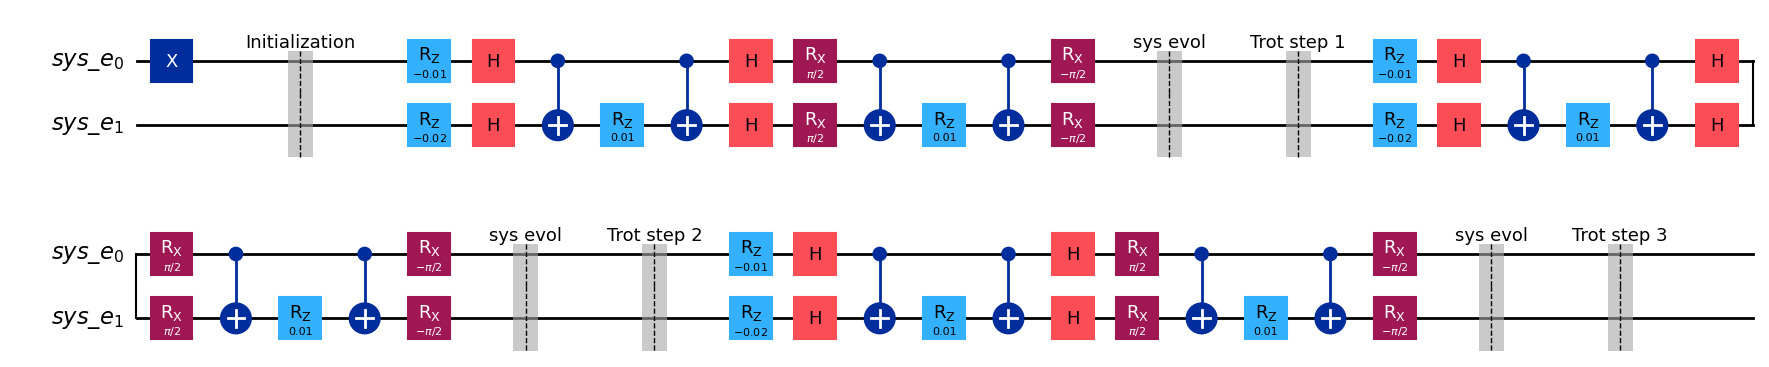

In [183]:
from qiskit import transpile

results = qevolve(esys, time, dt=dt)

qc_decomposed = transpile(results[3],
                          basis_gates=['cx', 'rx', 'rz', 'ry',
                                       'x', 'y', 'z', 'h'],
                          )
qc_decomposed.draw('mpl')

The evolution has been completed.


[[<matplotlib.lines.Line2D at 0x7fb004413d50>],

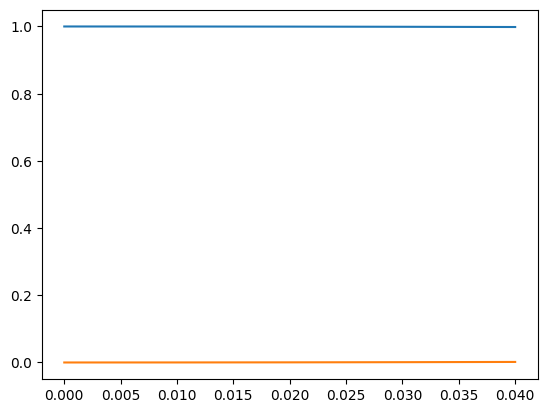

In [184]:
import matplotlib.pyplot as plt

results_qutip_sesolve = clevolve(esys, time, measure_populations=True)

P_qutip_s = results_qutip_sesolve.expect
error = [np.sqrt(P_qutip_s[i] * (np.ones_like(P_qutip_s[i]) - P_qutip_s[i]) / shots)
         for i in range(len(epsilon))]

[plt.plot(time, P_qutip_s[i]) for i in range(len(epsilon))]

**Dynamics with dephasing environment**

In [185]:
gamma = 0.1

Start creating the circuits...
Circuits created...


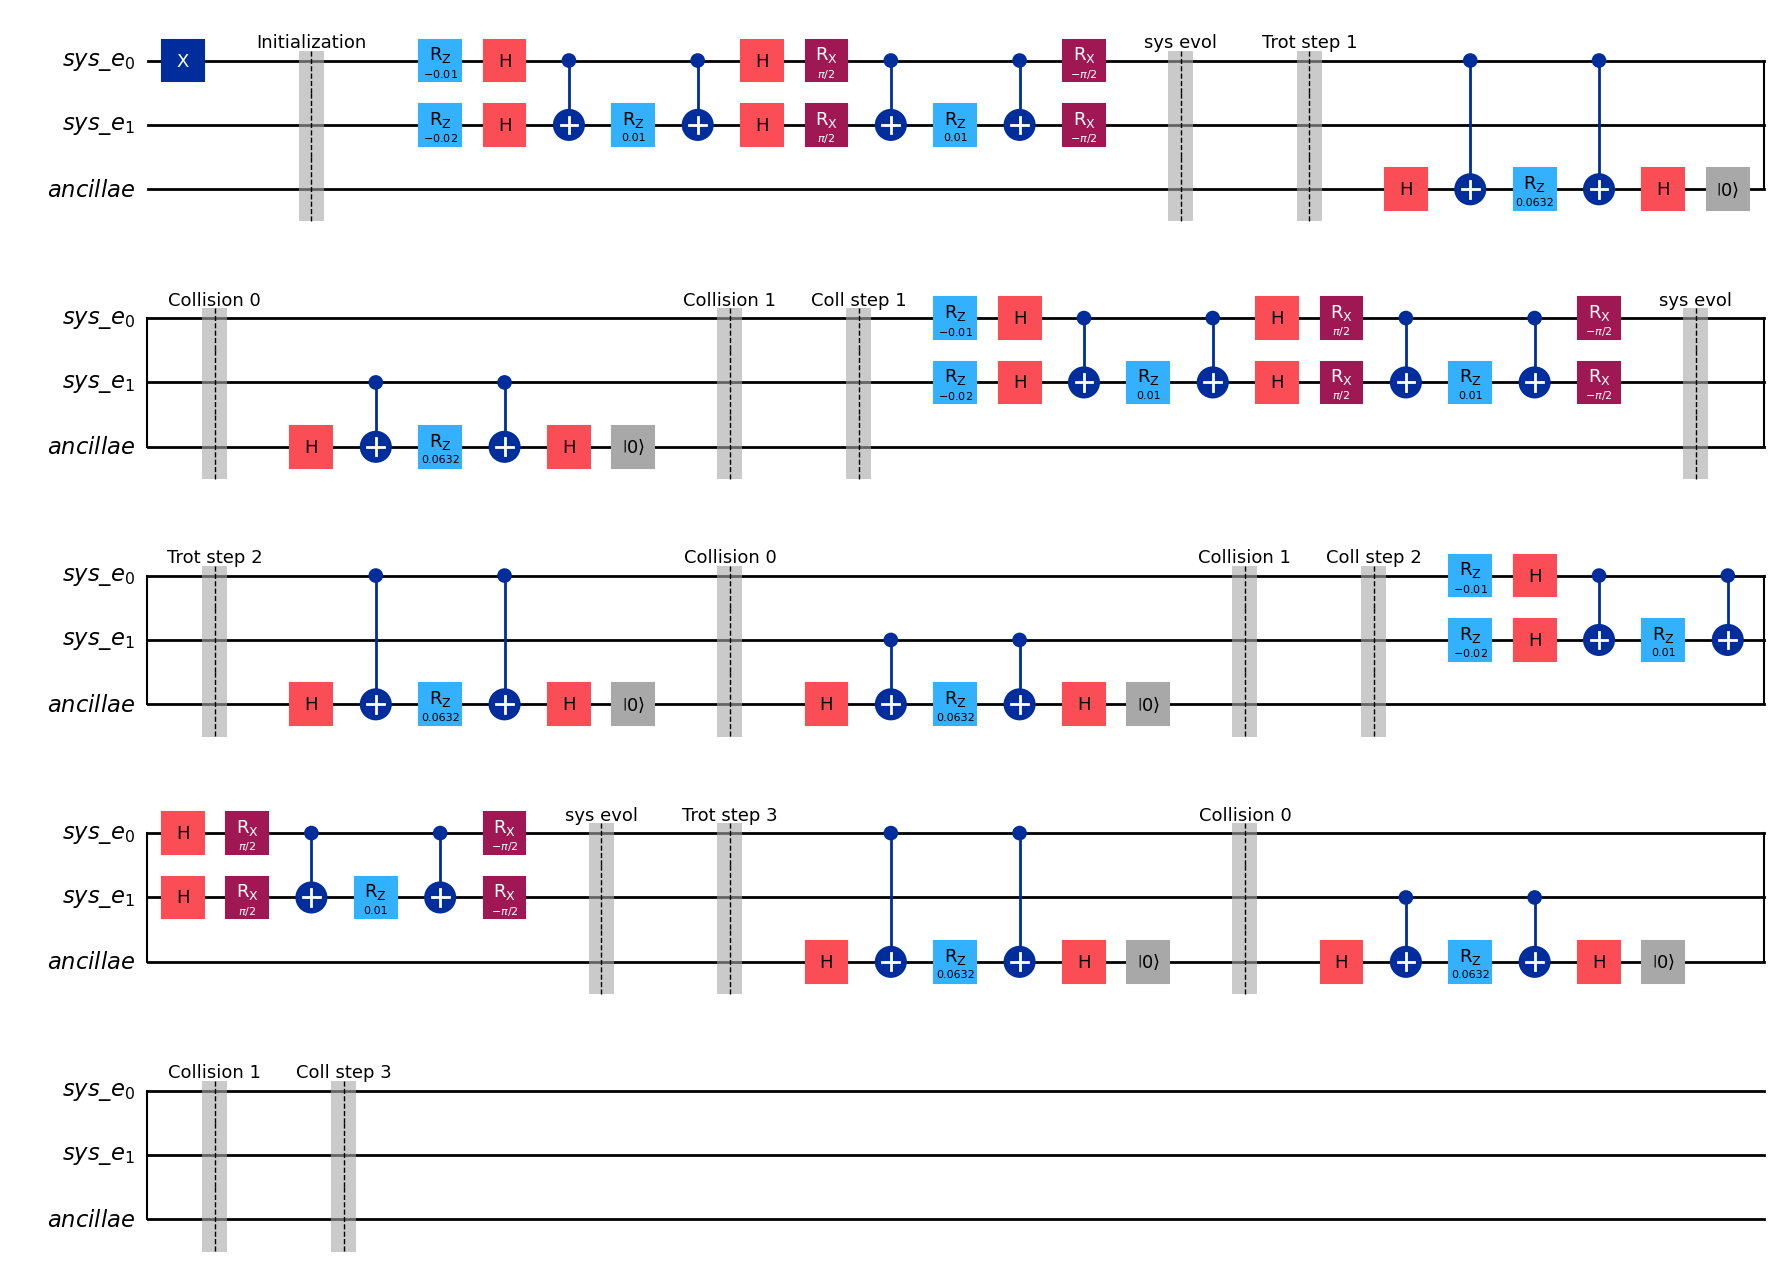

In [186]:
results = qevolve(esys, time, dt=dt, coll_rates=gamma)

qc_decomposed = transpile(results[3],
                          basis_gates=['cx', 'rx', 'rz', 'ry',
                                       'x', 'y', 'z', 'h'],
                          )
qc_decomposed.draw('mpl')

The evolution has been completed.


[[<matplotlib.lines.Line2D at 0x7fb005129ad0>],

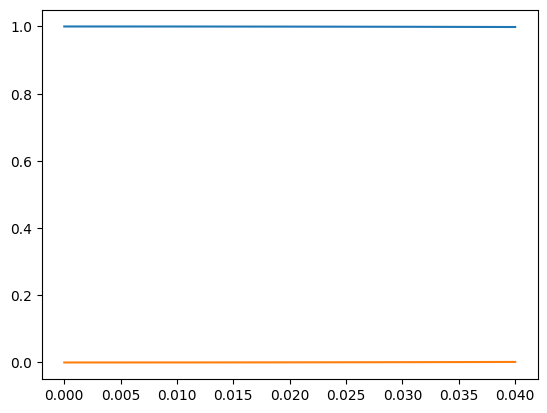

In [187]:
results_qutip_mesolve = clevolve(esys, time, gamma, measure_populations=True)

P_qutip_m = results_qutip_mesolve.expect
error = [np.sqrt(P_qutip_m[i] * (np.ones_like(P_qutip_m[i]) - P_qutip_m[i]) / shots)
         for i in range(len(epsilon))]

[plt.plot(time, P_qutip_m[i]) for i in range(len(epsilon))]

**Chromophore test**

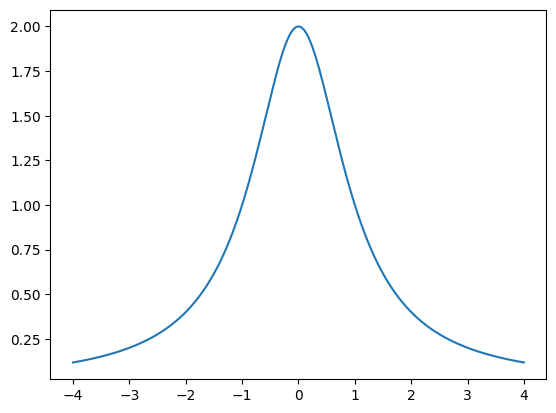

In [188]:
from scipy.linalg import toeplitz

sys = ChromophoreSystem(excitonic_system=esys)
frequencies_pseudomode = [0]
Gamma = [2]
Omega = [1]

fr, sf = spectral_function(frequencies_pseudomode, Gamma, Omega)
plt.plot(fr, sf)

DensityMatrix([[0.5+0.j, 0. +0.j, 0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0.5+0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j]],
              dims=(2, 2))
DensityMatrix([[0.5+0.j, 0. +0.j],
               [0. +0.j, 0.5+0.j]],
              dims=(2,))
Statevector([0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
            dims=(2, 2))
{'00': 515, '10': 509}


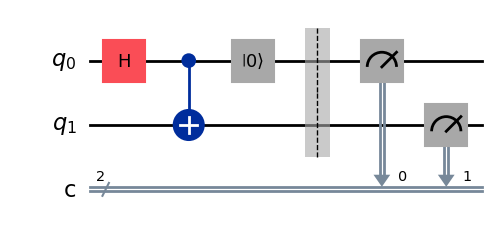

In [189]:
from qiskit.quantum_info import partial_trace


def bell_state():
    qc = QuantumCircuit(2, 2)
    qc.h(0)
    qc.cx(0, 1)
    qc.reset(0)
    qc.barrier()
    return qc


qc = bell_state()
qc.save_density_matrix()
simulator = AerSimulator(method='density_matrix')
result = simulator.run(qc).result()

dm = result.data()['density_matrix']
rdm = partial_trace(dm, [0])
print(dm)
print(rdm)

##

qc = bell_state()
qc.save_statevector()

simulator = AerSimulator(method='statevector')
result = simulator.run(qc).result()

statevector = result.get_statevector()
print(statevector)

##

qc = bell_state()
qc.measure([0, 1], [0, 1])
simulator = AerSimulator()
result = simulator.run(qc).result()

counts = result.get_counts()
print(counts)

qc.draw('mpl')

In [190]:
qc = QuantumCircuit(2, 2)
qc.h(0)
qc.cx(0, 1)
qc.reset(0)
qc.barrier()

simulator = AerSimulator()
result = simulator.run(qc).result()

In [191]:
sys.pseudomodes(frequencies_pseudomode=frequencies_pseudomode,
                levels_pseudomode=[2]*len(frequencies_pseudomode),
                couplings_ep=np.sqrt(
                    np.array(Gamma)*np.array(Omega)/2).tolist(),
                )

sys.get_ep_Hamiltonian()

Quantum object: dims=[[2, 2, 2, 2], [2, 2, 2, 2]], shape=(16, 16), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]]

In [192]:
sys.get_global_Hamiltonian()

Quantum object: dims=[[2, 2, 2, 2], [2, 2, 2, 2]], shape=(16, 16), type='oper', dtype=CSR, isherm=True
Qobj data =
[[-1.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.  -1.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.  -1.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.  -1.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.  -0.5  1.   0.   0.   1.   0.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   1.  -0.5  0.   0.   0.   1.   0.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.  -0.5  1.   0.   0.   1.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   1.  -0.5  0.   0.   0.   1.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   1.   0.   0.   0.   0.5  0.   1.   0.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   0.   1.   0.   0.   0.   0.5  0.   1.   0.   0.
   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   1.   0.   1.

In [193]:
dt = 0.01
time = np.arange(0, 5, dt*10)
shots = 10000

Start creating the circuits...


Circuits created...
Start measuring the circuits...


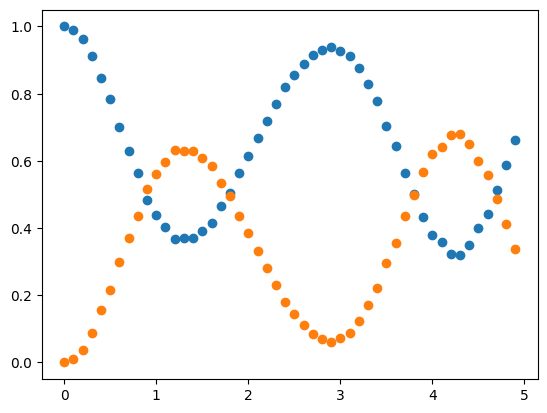

In [194]:
results = qevolve(sys, time, shots=shots, dt=dt)

P = np.zeros((len(epsilon), time.size))
counts = results.get_counts()
for nc, c in enumerate(counts):
    for i in range(len(epsilon)):
        try:
            P[i, nc] = c['{:b}'.format(1 << i).zfill(len(epsilon))]/shots
        except:
            P[i, nc] = 0

[plt.scatter(time, P[i, :]) for i in range(len(epsilon))]

The evolution has been completed.


[[<matplotlib.lines.Line2D at 0x7fb0053b4810>],

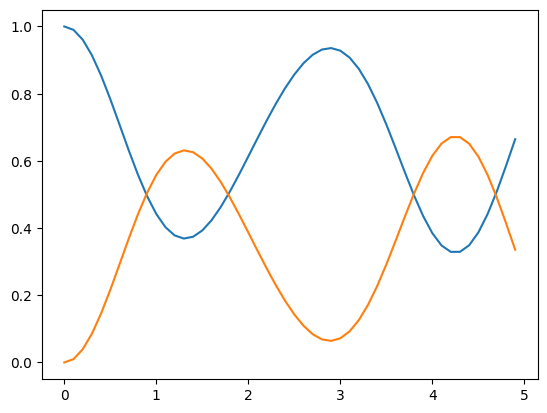

In [195]:
results_qutip = clevolve(sys, time, measure_populations=True)

P_qutip = results_qutip.expect
error = []
for i in range(len(epsilon)):
    error.append(
        np.sqrt(P_qutip[i] * (np.ones_like(P_qutip[i]) - P_qutip[i]) / shots))

[plt.plot(time, P_qutip[i]) for i in range(len(epsilon))]

**Dephasing**

In [196]:
coll_rate = (2 * np.array(Omega)).tolist()

print(coll_rate)

[2]


In [197]:
# results = qevolve(sys, time, shots=shots, dt=dt, coll_rates=coll_rate)

# P = np.zeros((len(epsilon), time.size))

# counts = results.get_counts()
# for nc, c in enumerate(counts):
#     for i in range(len(epsilon)):
#         try:
#             P[i, nc] = c['{:b}'.format(1 << i).zfill(len(epsilon))]/shots
#         except:
#             P[i, nc] = 0

# [plt.scatter(time, P[i, :]) for i in range(len(epsilon))]

In [198]:
results = qevolve(sys, time, shots=0, dt=dt, coll_rates=coll_rate)

Start creating the circuits...
Circuits created...
Extracting Density Matrix...


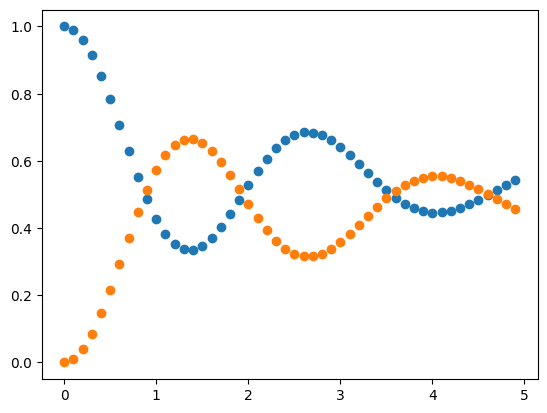

In [199]:
from qiskit.quantum_info import partial_trace

P = np.zeros((len(epsilon), time.size))

counts = []
for nr, result in enumerate(results):
    for i in range(len(epsilon)):
        try:
            P[i, nr] = result[f'{1 << i:0{len(epsilon)}b}']
        except:
            P[i, nr] = 0

[plt.scatter(time, P[i, :]) for i in range(len(epsilon))]

Start creating the circuits...
Circuits created...


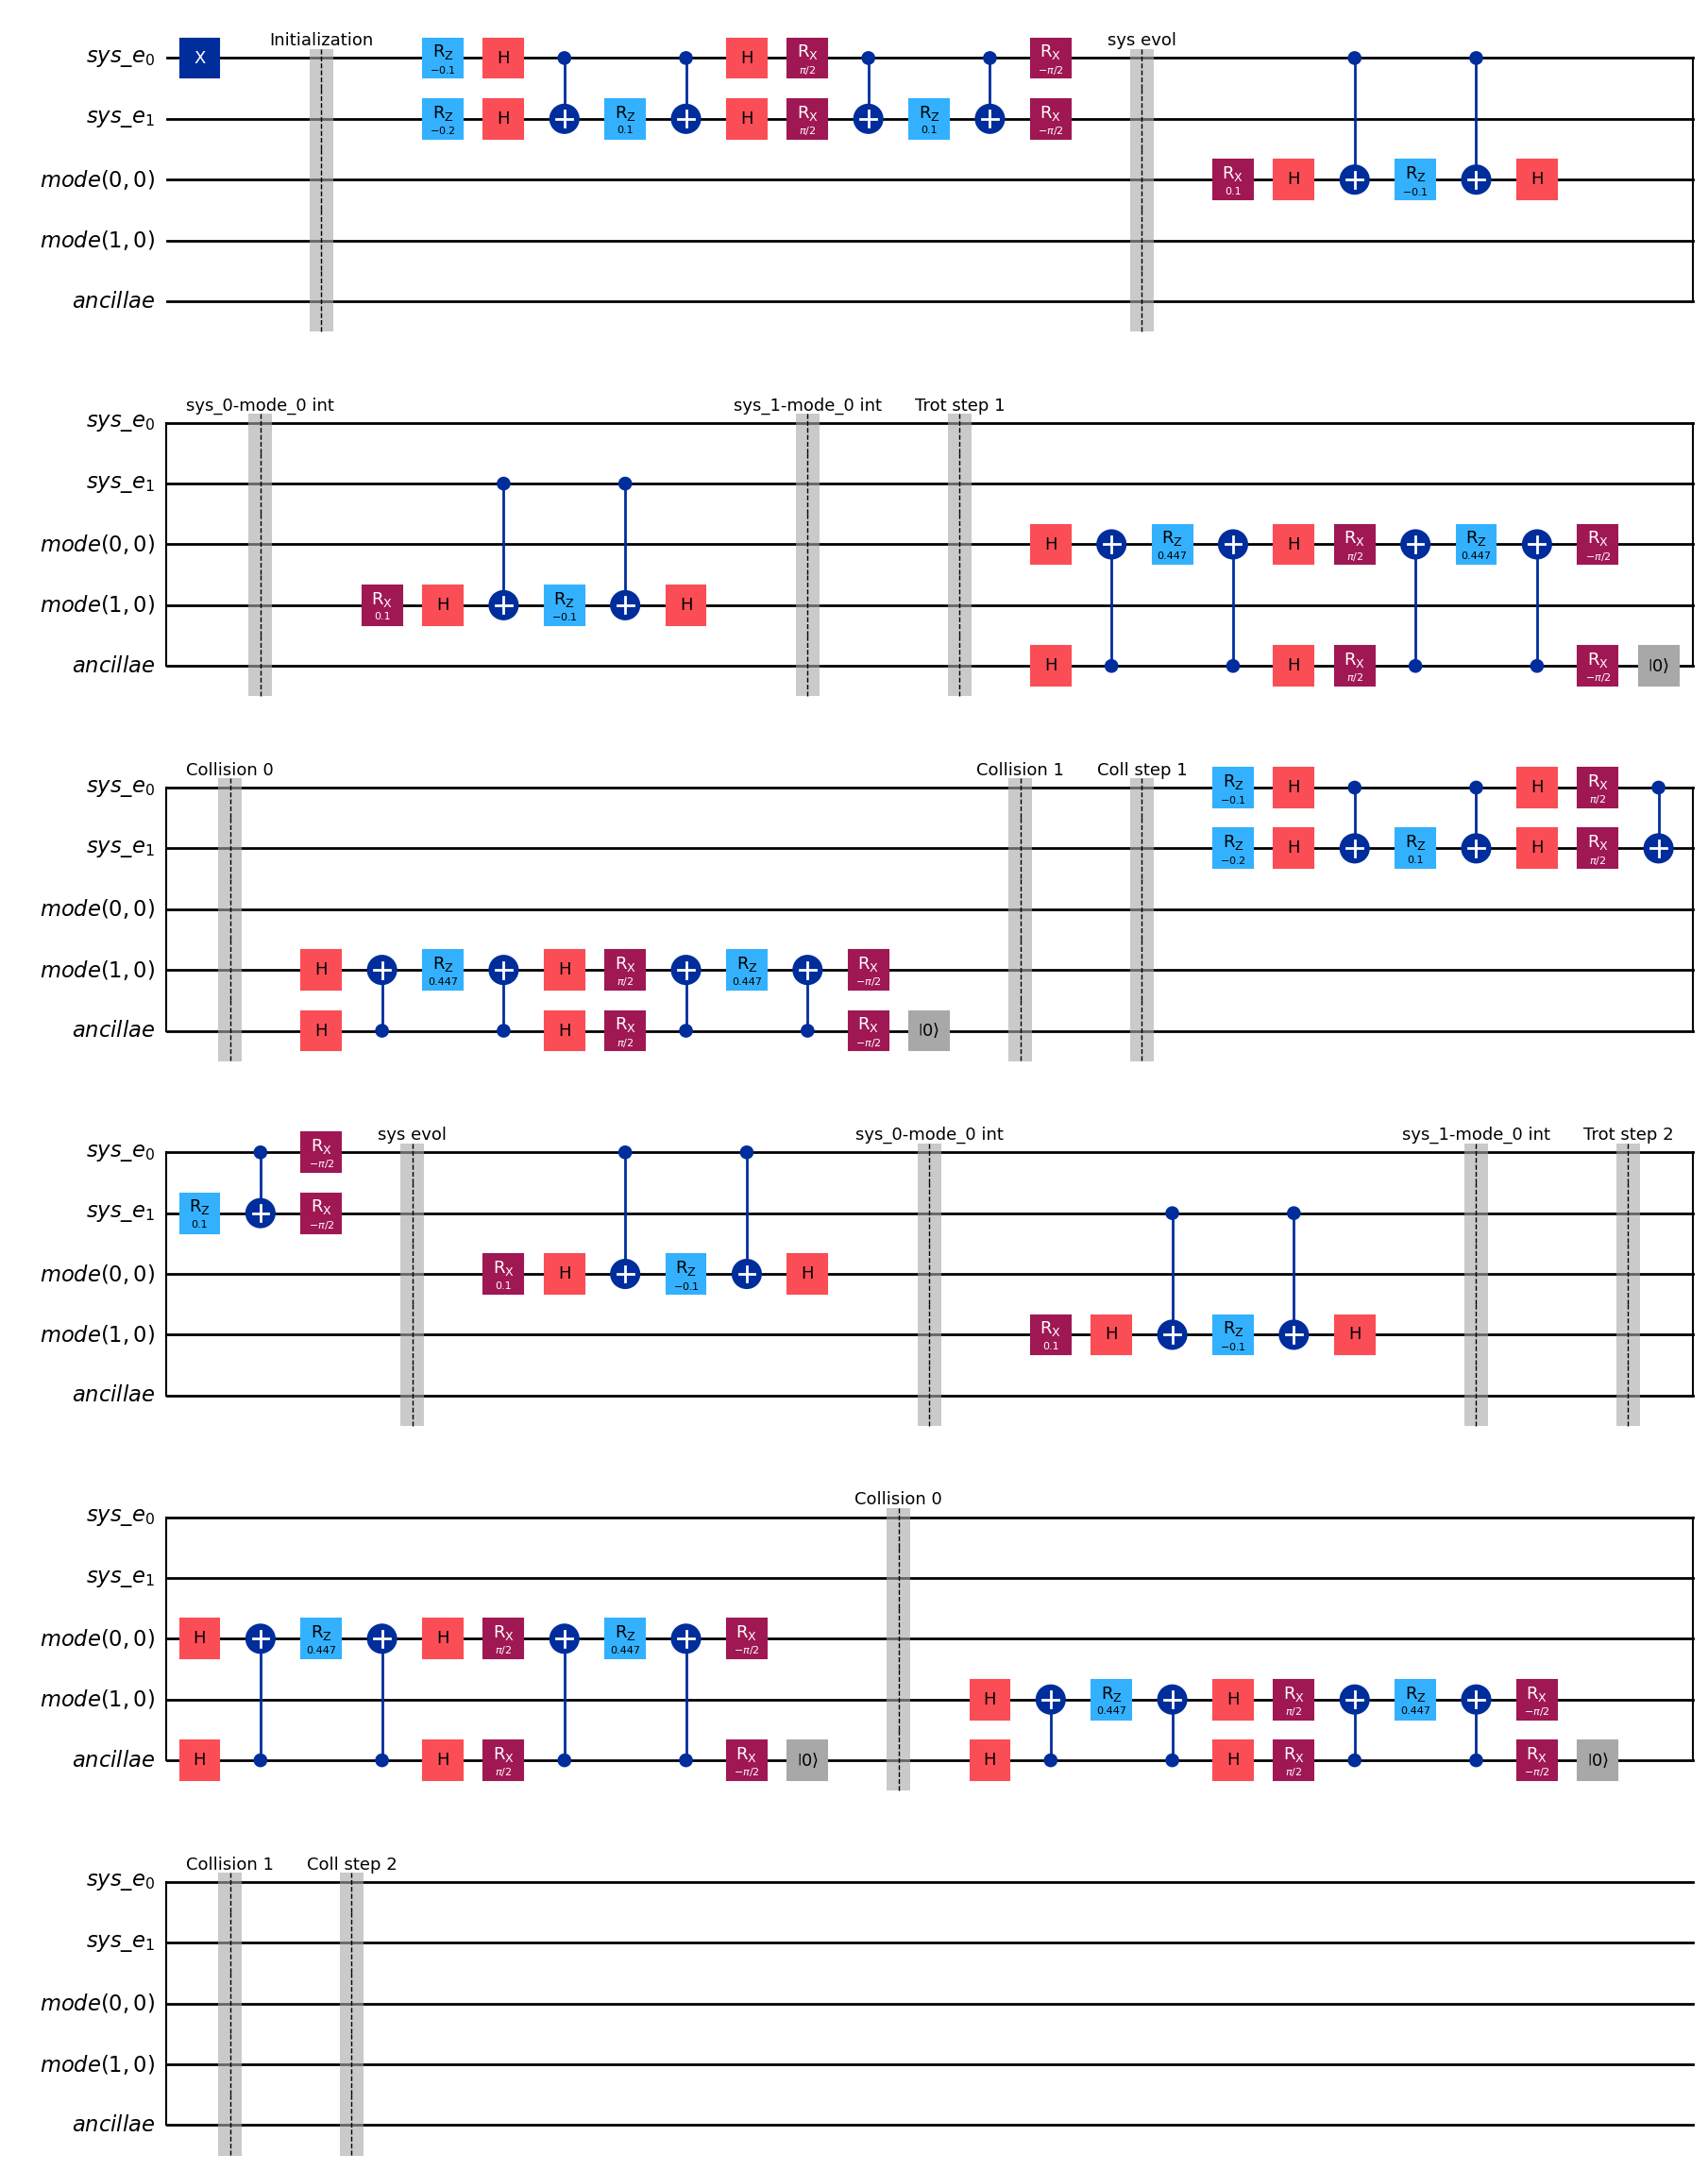

In [203]:
results = qevolve(sys, time, dt=dt*10, coll_rates=coll_rate)[2]

qc_decomposed = transpile(results,
                          basis_gates=['cx', 'rx', 'rz', 'ry',
                                       'x', 'y', 'z', 'h'])
qc_decomposed.draw('mpl')

The evolution has been completed.


[[<matplotlib.lines.Line2D at 0x7fd704168ad0>],

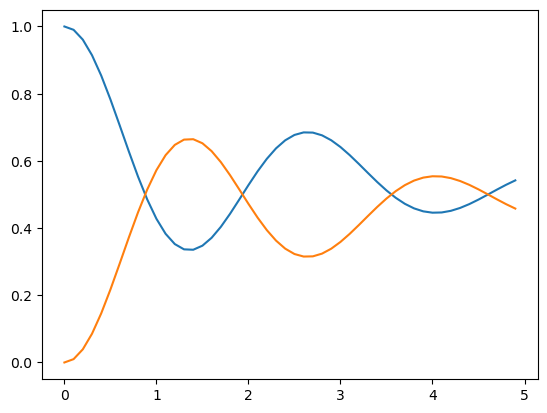

In [411]:
results = clevolve(sys, time, coll_rate, measure_populations=True)

P_qutip = results.expect
error = []
for i in range(len(epsilon)):
    error.append(
        np.sqrt(P_qutip[i] * (np.ones_like(P_qutip[i]) - P_qutip[i]) / shots))

[plt.plot(time, P_qutip[i]) for i in range(len(epsilon))]

[[0. 1. 0.]
 [1. 0. 1.]
 [0. 1. 0.]]
The evolution has been completed.


/tmp/ipykernel_30025/960698599.py:72: UserWarning: Equal dipole moments are assumed for all chromophores
  warnings.warn(


[[<matplotlib.lines.Line2D at 0x7f5daf7c6d90>],

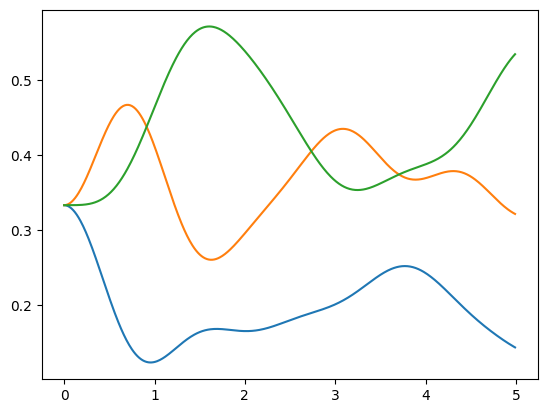

In [ ]:
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt

epsilon = [1, 2, 3]
J = toeplitz([0., 1., 0])
print(J)

esys = ExcitonicSystem(energies=epsilon, couplings=J)

esys.set_state(state_type='delocalized excitation',
               state=[1/np.sqrt(3)]*3)

sys = ChromophoreSystem(excitonic_system=esys)
frequencies_pseudomode = [0]
Gamma = [2]
Omega = [1]

sys.pseudomodes(frequencies_pseudomode=frequencies_pseudomode,
                levels_pseudomode=[2]*len(frequencies_pseudomode),
                couplings_ep=np.sqrt(
                    np.array(Gamma)*np.array(Omega)/2).tolist(),
                )

dt = 0.01
time = np.arange(0, 5, dt)
shots = 10000

coll_rate = 0.1
results = clevolve(sys, time, coll_rate, measure_populations=True)

P_qutip = results.expect
error = []
for i in range(len(epsilon)):
    error.append(
        np.sqrt(P_qutip[i] * (np.ones_like(P_qutip[i]) - P_qutip[i]) / shots))

[plt.plot(time, P_qutip[i]) for i in range(len(epsilon))]